In [1]:
## Step 1: Preprocessing
# - Define units: N, m
# - Prepare the design basis report
## Step 2: Importing Necessary Libraries
from dolfin import *
import numpy as np
import ufl, time, meshio, pygmsh
import matplotlib.pyplot as plt
import csv


In [2]:
# Set log level
set_log_level(LogLevel.ERROR)
comm = MPI.comm_world  # MPI communicator

## Step 3: Loading the Mesh
mesh = Mesh()
with XDMFFile("mesh/ice-adaptive.xdmf") as infile:
    infile.read(mesh)
mesh.hmin()


4.194026304469285

In [3]:
model = "stress_cdf"
is_adaptive = True

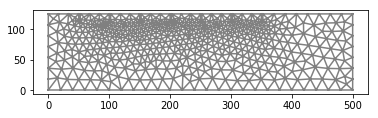

In [4]:
plot(mesh)

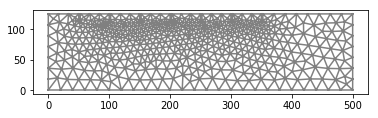

In [5]:
plot(mesh)

In [6]:
# Step 4: Preparing output file
xdmf = XDMFFile("output/Solution.xdmf")
xdmf.parameters["functions_share_mesh"] = True
xdmf.parameters["rewrite_function_mesh"] = True
xdmf.parameters["flush_output"] = True

In [7]:
# ---------------------------------------------------------------------------------
# MATERIAL MODEL  --------------------------------------------------------
# ---------------------------------------------------------------------------------
def epsilon(u):
    return 0.5 * (grad(u) + grad(u).T)


def sigma(u):
    return 2.0 * mu * epsilon(u) + lmbda * tr(epsilon(u)) * Identity(len(u))



In [8]:
# ---------------------------------------------------------------------------------
# CRACK DEPTH FUNCTION     --------------------------------------------------------
# ---------------------------------------------------------------------------------
def get_crack_tip_coord(dmg,Dx,  damage_threshold=0.6):
    y_co_ord = Function(Dx)
    y_co_ord.interpolate(Expression("x[1]", degree=1))
    dmg_dg_1 = project(dmg, Dx)
    coord_vec = y_co_ord.vector()[dmg_dg_1.vector()[:] >= damage_threshold]
    coord = 115  # ToDo: Change this
    if coord_vec.size > 0:
        coord = coord_vec.min()
    return MPI.min(comm, coord)


In [9]:
# ---------------------------------------------------------------------------------
# DOMAIN SIZE # PROBLEM PARAMETERS    ---------------------------------------------
# ---------------------------------------------------------------------------------
hs_ratio = 0.0  # water level in crevasse (normalized with crevasse height)
hw_ratio = 0.5  # water level at right terminus (normalized with glacier thickness)
prec_ratio = 0.08  # depth of pre-crack (normalized with glacier thickness)
L, H = 500, 125
hw = hw_ratio*H

####### Threshold for energy
energy_thsd= 5
targeted_him = 0.2
alpha_2 = 0.3 # threshold for damage



In [10]:
# ---------------------------------------------------------------------------------
# MATERIAL PARAMETERS     ------------------------------------------------
# ---------------------------------------------------------------------------------

E = 9.5e9  # Young's modulus (Pa)
nu = 0.35  # Poisson's ratio
KIc = 0.1e6  # critical stress intensity factor (Pa*m^0.5)
rho_ice = 917  # density of ice (kg/m^3)

# rho_ice = 917  # density of ice (kg/m^3)
rho_H2O = 1000  # density of freshwater (kg/m^3)
rho_sea = 1020  # density of seawater (kg/m^3)
grav = 9.81  # gravity acceleration (m/s**2)

mu = E / 2 / (1 + nu)  # shear modulus
K = E / 3 / (1 - 2 * nu)  # bulk modulus
lmbda = K - 2 / 3 * mu  # Lame's first parameter

lc = 0.625  # nonlocal length scale (m)
l = lc

  # water level at terminus (absolute height)
ci = 1

sigmac = 0.1185e6  # critical stress only for stress based method

In [11]:

# ---------------------------------------------------------------------------------
# PARAMETERS FOR PARALLEL COMPUTATIONS   -----------------------------
# ---------------------------------------------------------------------------------


rank = comm.Get_rank()  # number of current process
size = comm.Get_size()  # total number of processes


def mwrite(filename, my_list):
    MPI.barrier(comm)
    if rank == 0:
        with open(filename, "w") as f:
            for item in my_list:
                f.write("%s" % item)


def mprint(*argv):
    if rank == 0:
        out = ""
        for arg in argv:
            out = out + str(arg)
        # this forces program to output when run in parallel
        print(out, flush=True)


In [12]:
# ---------------------------------------------------------------------------------
# ENERGY CALCULATIONS        ------------------------------------------------
# ---------------------------------------------------------------------------------
def applyElementwise(f, T):
    sh = ufl.shape(T)
    if len(sh) == 0:
        return f(T)
    fT = []
    for i in range(0, sh[0]):
        fT += [applyElementwise(f, T[i])]
    return as_tensor(fT)


def split_plus_minus(T):
    x_plus = applyElementwise(lambda x: 0.5 * (abs(x) + x), T)
    x_minus = applyElementwise(lambda x: 0.5 * (abs(x) - x), T)
    return x_plus, x_minus


def safeSqrt(x):
    return sqrt(x + DOLFIN_EPS)


def principal_tensor(t):
    eig1 = 0.5 * (tr(t) + safeSqrt(tr(t) * tr(t) - 4 * det(t)))
    eig2 = 0.5 * (tr(t) - safeSqrt(tr(t) * tr(t) - 4 * det(t)))
    return as_tensor([[eig1, 0], [0, eig2]])

# Energy function with strain-based
def get_psi(unew):
    dim = unew.function_space().mesh().topology().dim()
    strain = epsilon(unew)
    if dim == 1:
        principal_strain = strain
    else:
        principal_strain = get_eigenstate(strain)
        strain_plus, strain_minus = split_plus_minus(principal_strain)
        tr_pr_strain = tr(principal_strain)
        tr_pr_str_plus, tr_pr_str_minus = split_plus_minus(tr_pr_strain)
        si_plus = lmbda / 2 * (tr_pr_str_plus ** 2) + mu * (inner(strain_plus, strain_plus))
    return si_plus




# -----------------------------------------------------------------------------
# 2D eigen decomposition
# -----------------------------------------------------------------------------

def get_eigenstate(t):
    eig1 = 0.5 * (tr(t) + safeSqrt(tr(t) * tr(t) - 4 * det(t)))
    eig2 = 0.5 * (tr(t) - safeSqrt(tr(t) * tr(t) - 4 * det(t)))
    return as_tensor([[eig1, 0], [0, eig2]])

def get_energy(unew,pnew,D):
    if model == "stress_cdf":
        # stress_plus, stress_minus = split_plus_minus(get_eigenstate(sigma(unew)))
        stress_plus = get_eigenstate(sigma(unew))
        energy_expr = ci * ((ufl.Max(stress_plus[0, 0],0)**2 + ufl.Max(stress_plus[1, 1],0)**2)/sigmac ** 2  - 1)
        energy_expr = ufl.Max(energy_expr, 0)
        energy_expr = ufl.conditional(ufl.le(energy_expr, energy_thsd), 0, energy_expr)
    return energy_expr


def get_energy1(unew):
    if model == "stress_cdf":
        # stress_plus, stress_minus = split_plus_minus(get_eigenstate(sigma(unew)))
        stress_plus = get_eigenstate(sigma(unew))
        energy_expr = ci * ((ufl.Max(stress_plus[0, 0],0)**2 + ufl.Max(stress_plus[1, 1],0)**2)/sigmac ** 2  - 1)
        energy_expr = ufl.Max(energy_expr, 0)
        energy_expr = ufl.conditional(ufl.le(energy_expr, energy_thsd), 0, energy_expr)
        return energy_expr
    
## A pure Rankine-type criterion would be related to the phase field driving force:
    
def get_energy_Rankine(disp, type="stress"):
    if type == "stress":
        principal_stress = principal_tensor(sigma(unew))
        stress_plus, stress_minus = split_plus_minus(principal_stress)
        # Take max between stress_xx and stress_yy
        max_stress = ufl.Max(stress_plus[0, 0], stress_plus[1, 1])
        energy_expr = ci * (max_stress**2/sigmac ** 2  - 1)
        energy_expr = ufl.Max(energy_expr, 0)
        
        # Apply the threshold condition
        energy_expr = ufl.conditional(ufl.le(energy_expr, energy_thsd), 0, energy_expr)
#         energy = project(energy_expr, DG).vector()[:]
        return energy_expr

In [ ]:
def estimate_change_in_stress(cdf_old,cdf_new):
    DG = FunctionSpace(mesh, "DG", 0)
    error_estimate = project(cdf_new - cdf_old, DG).vector()[:]
    return error_estimate

# def get_markers(marker_array, mesh, phi, Y0, cdf, alpa, target_hmin, psi):
#     min_achieved = False
#     DG = FunctionSpace(mesh, "DG", 0)

#     marker = MeshFunction("bool", mesh, mesh.topology().dim())
#     marker.set_all(False)
#     # ---------------------------------------------------------------------------------
#     # Scheme S1    -----------------------------------------------------
#     # ---------------------------------------------------------------------------------
#     #  elements are refined, for which the value of error indicator is greater than α·max(error indicator)
#     maximum_value = MPI.max(comm,max(marker_array))
#     alpha_max = alpa * maximum_value
#     marker.array()[marker_array > alpha_max] = True
#     # ---------------------------------------------------------------------------------
#     # Scheme S2    -----------------------------------------------------
#     # ---------------------------------------------------------------------------------
# #     marker.array()[project(psi,DG).vector()[:] > 0.8*Y0] = True
#     # marker.array()[project(psi,DG).vector()[:] < 0.8*Y0] = False
#     # ---------------------------------------------------------------------------------
#     # Scheme S3    -----------------------------------------------------
#     # ---------------------------------------------------------------------------------
#     marker.array()[project(phi,DG).vector()[:] > 0.2] = True
#     # ---------------------------------------------------------------------------------
#     # Scheme S4    -----------------------------------------------------
#     # ---------------------------------------------------------------------------------
#     cell_dia = Circumradius(mesh)
    
#     dia_vector = project(cell_dia, DG, solver_type="cg",
#         preconditioner_type="hypre_euclid").vector()[:]
#     marker.array()[dia_vector < target_hmin] = False
#     # ---------------------------------------------------------------------------------
#     # ---------------------------------------------------------------------------------
#     DG = None
#     del DG

#     min_achieved =    np.all(np.invert(marker.array()))
#     return marker, min_achieved

In [ ]:
def problem(mesh, ms_iterations=1, u_adaptive=None, p_adaptive=None, cdf_adaptive=None):
    # Step 5: Preparing the sets
    support_left = CompiledSubDomain("on_boundary && near(x[0], 0.0, tol)", tol=1e-14)
    support_bottom = CompiledSubDomain("on_boundary && near(x[1], 0.0, tol)", tol=1e-14)
    load_right = CompiledSubDomain("on_boundary &&  x[0] == 500")  # Example value for hw

    mf_line = MeshFunction("size_t", mesh, 1)
    load_right.mark(mf_line, 1)

    ds = Measure("ds", subdomain_data=mf_line)

    # Step 6: Defining spaces
    V1 = VectorFunctionSpace(mesh, "CG", 1)
    F1 = FunctionSpace(mesh, "CG", 1)

    FDG0 = FunctionSpace(mesh, "DG", 0)
    TDG0 = TensorFunctionSpace(mesh, "DG", 0)

    # Step 7: Define functions
    u = TrialFunction(V1)
    v = TestFunction(V1)
    unew, uold = Function(V1, name="disp"), Function(V1, name="disp")
    stress_xx = Function(F1, name="sigma_xx")
    cdf = Function(FDG0, name="cdf")

    p = TrialFunction(F1)
    q = TestFunction(F1)
    pnew, pold = Function(F1, name="damage"), Function(F1, name="damage")
    
    # Step 8: Update old data (New to old)

    if u_adaptive is not None:
        uold.assign(project(u_adaptive, V1))
        unew.assign(project(u_adaptive, V1))
        
    if p_adaptive is not None:
        pold.assign(project(p_adaptive, F1))
        pnew.assign(project(p_adaptive, F1))
        
    if cdf_adaptive is not None:
        cdf.assign(project(cdf_adaptive, FDG0))



    # Step 9: Define supports
    bc_sp_x = DirichletBC(V1.sub(0), Constant(0.0), support_left)
    bc_sp_y = DirichletBC(V1.sub(1), Constant(0.0), support_bottom)
    bc_u = [bc_sp_x, bc_sp_y]

    # Step 10: Define Loads
    t = Expression(("(h - x[1] >= 0 ?-rho_H2O * grav*(h - x[1]) : 0)", 0), rho_H2O=rho_sea,grav=grav, h = hw, degree=1)
    f = Constant((0, -rho_ice * grav))

    # Step 11: Displacement and Damage Problems
    disp_a = inner(((1 - pold) ** 2 + 1e-4) * sigma(u), epsilon(v)) * dx
    disp_L = (1-pold)*dot(f, v) * dx + dot(t, v) * ds(1)
#     disp_L = dot(f, v) * dx + dot(t, v) * ds(1)


    phase_a = (l**2 * inner(grad(p), grad(q)) + (1) * inner(p, q) + cdf * inner(p, q)) * dx
    phase_L = inner(cdf, q) * dx

    # Step 12: Solve
    disp_problem = LinearVariationalProblem(disp_a, disp_L, unew, bc_u)
    disp_solver = LinearVariationalSolver(disp_problem)

    phase_problem = LinearVariationalProblem(phase_a, phase_L, pnew)
    phase_solver = LinearVariationalSolver(phase_problem)

#     prm_disp = disp_solver.parameters
#     prm_disp["linear_solver"] = "gmres"
#     prm_disp["preconditioner"] = "hypre_euclid"

#     prm_phase = phase_solver.parameters
#     prm_phase["linear_solver"] = "gmres"
#     prm_phase["preconditioner"] = "hypre_euclid"

    # Start iterations
    disp_solver.solve()

    # Update history variable
    cdf.vector()[:] = np.maximum(project(get_energy(unew, pnew, FDG0),FDG0 ).vector()[:], cdf.vector()[:])
#     cdf.vector()[:] = project(get_energy(unew, pnew, FDG0),FDG0 ).vector()[:]

    phase_solver.solve()
    # Clip the damage solution to 0-1
    pnew.vector()[:] = np.clip(pnew.vector()[:], 0, 1)

    err_u = sqrt(assemble((unew - uold)**2 * dx))
    err_phi = sqrt(assemble((pnew - pold)**2 * dx))
    ms_err = max(err_u, err_phi)
    print("err - u - ", err_u, " -- err - phi - ", err_phi)

    min_ms_achieved = False
    if ms_err < 1e-5 or ms_iterations >= 1:
        min_ms_achieved = True

    return unew, pnew, cdf


In [ ]:
def get_markers(phi, mesh, target_hmin):
    adaptivity_converged = False

    marker = MeshFunction("bool", mesh, mesh.topology().dim())
    marker.set_all(False)

    DG = FunctionSpace(mesh, "DG", 0)
    phi.assign(project(phi, DG))
    marker.array()[phi.vector()[:] > alpha_2] = True
    # ---------------------------------------------------------------------------------
    # Scheme S4    -----------------------------------------------------
    # ---------------------------------------------------------------------------------
    cell_dia = Circumradius(mesh)
    dia_vector = project(cell_dia, DG, solver_type="cg",
                         preconditioner_type="hypre_euclid").vector()[:]
    marker.array()[dia_vector < target_hmin] = False
    # ---------------------------------------------------------------------------------
    # ---------------------------------------------------------------------------------
    DG = None
    del DG

    adaptivity_converged = np.all(np.invert(marker.array()))
    return marker, adaptivity_converged

err - u -  1.3664115523525218  -- err - phi -  10.13376490585977
err - u -  1.3692512087000819  -- err - phi -  5.457721412219779
err - u -  1.3710341424313564  -- err - phi -  4.740379006219215
err - u -  1.3717773926660322  -- err - phi -  4.202269046969127
err - u -  1.372401261482222  -- err - phi -  4.007218129930719
err - u -  1.3733851167884523  -- err - phi -  3.9528811266020862
err - u -  1.3738057761068028  -- err - phi -  3.9407131786307112
err - u -  1.3738335457626085  -- err - phi -  3.928497832221579


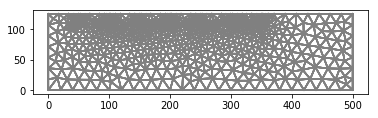

In [ ]:
adaptivity_converged = False

while not adaptivity_converged:
    uold, pold,cdf_old = problem(mesh, 1)
    marker, adaptivity_converged = get_markers(pold, mesh, target_hmin=targeted_him)
    # print(adaptivity_converged)
    mesh = refine(mesh, marker)
    plot(mesh)

In [ ]:
mesh.hmin(), mesh.num_cells()

(0.0964767526610143, 4913)

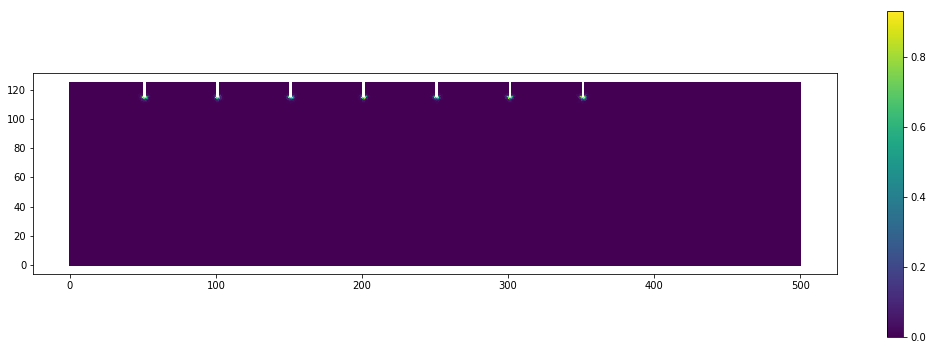

In [ ]:
plt.figure(figsize=(18, 6))
c = plot(pold)
plt.colorbar(c)  # Adds the colorbar
plt.show()

In [ ]:
#  ▄▄       ▄▄  ▄▄▄▄▄▄▄▄▄▄▄  ▄▄▄▄▄▄▄▄▄▄▄  ▄▄        ▄
# ▐░░▌     ▐░░▌▐░░░░░░░░░░░▌▐░░░░░░░░░░░▌▐░░▌      ▐░▌
# ▐░▌░▌   ▐░▐░▌▐░█▀▀▀▀▀▀▀█░▌ ▀▀▀▀█░█▀▀▀▀ ▐░▌░▌     ▐░▌
# ▐░▌▐░▌ ▐░▌▐░▌▐░▌       ▐░▌     ▐░▌     ▐░▌▐░▌    ▐░▌
# ▐░▌ ▐░▐░▌ ▐░▌▐░█▄▄▄▄▄▄▄█░▌     ▐░▌     ▐░▌ ▐░▌   ▐░▌
# ▐░▌  ▐░▌  ▐░▌▐░░░░░░░░░░░▌     ▐░▌     ▐░▌  ▐░▌  ▐░▌
# ▐░▌   ▀   ▐░▌▐░█▀▀▀▀▀▀▀█░▌     ▐░▌     ▐░▌   ▐░▌ ▐░▌
# ▐░▌       ▐░▌▐░▌       ▐░▌     ▐░▌     ▐░▌    ▐░▌▐░▌
# ▐░▌       ▐░▌▐░▌       ▐░▌ ▄▄▄▄█░█▄▄▄▄ ▐░▌     ▐░▐░▌
# ▐░▌       ▐░▌▐░▌       ▐░▌▐░░░░░░░░░░░▌▐░▌      ▐░░▌
#  ▀         ▀  ▀         ▀  ▀▀▀▀▀▀▀▀▀▀▀  ▀        ▀▀

In [ ]:
cpp_code = """
#include <pybind11/pybind11.h>
#include <dolfin/adaptivity/adapt.h>
#include <dolfin/function/Function.h>
#include <dolfin/mesh/Mesh.h>
namespace py = pybind11;
PYBIND11_MODULE(SIGNATURE, m)
{
m.def("adapt", [](const dolfin::Function &function,
          std::shared_ptr<const dolfin::Mesh> adapted_mesh,
                  bool interpolate){
             return dolfin::adapt(function, adapted_mesh, interpolate);});
}
"""
m = compile_cpp_code(cpp_code)


def adaptFunction(f, mesh, interp=True):
    return m.adapt(f, mesh, interp)


def transfer(_p, mesh):
    _p = Function(adaptFunction(_p._cpp_object, mesh))
    return _p

In [ ]:
# import csv
# # Specify the CSV file path
# csv_file_path = "output/crevasse_depth_with_Ki"+".csv"
# file = open(csv_file_path, mode='a', newline='')
# writer = csv.writer(file)
# writer.writerow(['step', 'cracktip_ratio', 'time', 'ELM'])

In [ ]:
# Storage for time and CDF values
cdf_data = []
time_data = []


In [ ]:
p_adaptive_n = pold
u_adaptive_n = uold
cdf_adaptive_n = cdf_old
start = time.time()

time_elapsed = 0
while time_elapsed < 100:
    
    adaptivity_converged = False
    while not adaptivity_converged:
        u_adaptive_n_1, p_adaptive_n_1, cdf_adaptive_n_1 = problem(mesh, 1, u_adaptive_n, p_adaptive_n, cdf_adaptive_n)
        marker, adaptivity_converged = get_markers(p_adaptive_n_1, mesh, target_hmin=targeted_him)
        # print(adaptivity_converged)
        mesh = refine(mesh, marker)
        p_adaptive_n = transfer(p_adaptive_n, mesh)
        u_adaptive_n = transfer(u_adaptive_n, mesh)
        cdf_adaptive_n = transfer(cdf_adaptive_n, mesh)


    p_adaptive_n.assign(p_adaptive_n_1)
    u_adaptive_n.assign(u_adaptive_n_1)
    cdf_adaptive_n.assign(cdf_adaptive_n_1)
#     psi_old.assign(psi_old)
   
    # Write the data
    p_adaptive_n.rename("damage", "damage")
    u_adaptive_n.rename("disp", "disp")
    cdf_adaptive_n.rename("cdf", "cdf")

    

    xdmf.write(p_adaptive_n, time_elapsed+1)
    xdmf.write(u_adaptive_n, time_elapsed+1)
    xdmf.write(cdf_adaptive_n, time_elapsed+1)
    
    
    
    
    # Increse time_elapsed
    time_elapsed +=1
    
    # Define new functions to print data    
    CE = FunctionSpace(mesh, "DG", 0)  # CDF
    Dx = FunctionSpace(mesh, "CG", 1)  # CDF


    # Determine crack tip coordinate
    cracktip_coor = get_crack_tip_coord(p_adaptive_n, Dx=Dx)
    
    # Print
    mprint(
    "step: {0:3}, cracktip_ratio: {1:6.3f}, hmin: {2:5.2f}, time: {3:6.0f}, cdf: {4:6.2f}, adaptivity_converged: {5:6d}, cells:{6:6} ".format(
        time_elapsed,
        1 - cracktip_coor / H,
        MPI.min(comm,mesh.hmin()),
        time.time() - start,
        max(cdf_adaptive_n.vector().vec().array[:]),
        adaptivity_converged,
        format(CE.dim())
    )
    )
    
#     time_steps.append(time_elapsed)
    
    
    
    
#     writer.writerow([time_elapsed,1 - cracktip_coor / H,time.time() - start, (CE.dim())])
#     file.flush()
    

err - u -  0.004329807284323775  -- err - phi -  3.821385709515924
err - u -  0.0049200021051895495  -- err - phi -  3.701043270071862
err - u -  0.0049594047741422734  -- err - phi -  3.6631324059191046
step:   1, cracktip_ratio:  0.101, hmin:  0.10, time:      2, cdf: 317.30, adaptivity_converged:      1, cells:7493   
err - u -  0.0050455266572542725  -- err - phi -  3.5678011731550985
err - u -  0.005124243866569941  -- err - phi -  3.4226301113467406
err - u -  0.005142327030357425  -- err - phi -  3.434018074963764
err - u -  0.005156340016973961  -- err - phi -  3.423678954523705
err - u -  0.005169908982423874  -- err - phi -  3.424892109228234
step:   2, cracktip_ratio:  0.113, hmin:  0.10, time:      5, cdf: 2491.67, adaptivity_converged:      1, cells:9889   
err - u -  0.004862175840597243  -- err - phi -  3.392461560275838
err - u -  0.00538366953544785  -- err - phi -  3.3328736226761997
err - u -  0.005397714372106414  -- err - phi -  3.3079441085736745
err - u -  0.0054

In [ ]:
plt.figure(figsize=(18, 6))
c = plot(p_adaptive_n)
plt.colorbar(c)  # Adds the colorbar
plt.show()

In [ ]:
plot(mesh)